# Assignment 4

Before working on this assignment please read these instructions fully. In the submission area, you will notice that you can click the link to **Preview the Grading** for each step of the assignment. This is the criteria that will be used for peer grading. Please familiarize yourself with the criteria before beginning the assignment.

This assignment requires that you to find **at least** two datasets on the web which are related, and that you visualize these datasets to answer a question with the broad topic of **sports or athletics** (see below) for the region of **Ann Arbor, Michigan, United States**, or **United States** more broadly.

You can merge these datasets with data from different regions if you like! For instance, you might want to compare **Ann Arbor, Michigan, United States** to Ann Arbor, USA. In that case at least one source file must be about **Ann Arbor, Michigan, United States**.

You are welcome to choose datasets at your discretion, but keep in mind **they will be shared with your peers**, so choose appropriate datasets. Sensitive, confidential, illicit, and proprietary materials are not good choices for datasets for this assignment. You are welcome to upload datasets of your own as well, and link to them using a third party repository such as github, bitbucket, pastebin, etc. Please be aware of the Coursera terms of service with respect to intellectual property.

Also, you are welcome to preserve data in its original language, but for the purposes of grading you should provide english translations. You are welcome to provide multiple visuals in different languages if you would like!

As this assignment is for the whole course, you must incorporate principles discussed in the first week, such as having as high data-ink ratio (Tufte) and aligning with Cairo’s principles of truth, beauty, function, and insight.

Here are the assignment instructions:

 * State the region and the domain category that your data sets are about (e.g., **Ann Arbor, Michigan, United States** and **sports or athletics**).
 * You must state a question about the domain category and region that you identified as being interesting.
 * You must provide at least two links to available datasets. These could be links to files such as CSV or Excel files, or links to websites which might have data in tabular form, such as Wikipedia pages.
 * You must upload an image which addresses the research question you stated. In addition to addressing the question, this visual should follow Cairo's principles of truthfulness, functionality, beauty, and insightfulness.
 * You must contribute a short (1-2 paragraph) written justification of how your visualization addresses your stated research question.

What do we mean by **sports or athletics**?  For this category we are interested in sporting events or athletics broadly, please feel free to creatively interpret the category when building your research question!

## Tips
* Wikipedia is an excellent source of data, and I strongly encourage you to explore it for new data sources.
* Many governments run open data initiatives at the city, region, and country levels, and these are wonderful resources for localized data sources.
* Several international agencies, such as the [United Nations](http://data.un.org/), the [World Bank](http://data.worldbank.org/), the [Global Open Data Index](http://index.okfn.org/place/) are other great places to look for data.
* This assignment requires you to convert and clean datafiles. Check out the discussion forums for tips on how to do this from various sources, and share your successes with your fellow students!

## Example
Looking for an example? Here's what our course assistant put together for the **Ann Arbor, MI, USA** area using **sports and athletics** as the topic. [Example Solution File](./readonly/Assignment4_example.pdf)

### Assignment 4 Summary
Region: Global

Domain: Sports

Resaerch Question:
What countries have been most succesful at the Olympics, and is that success influenced by wealth (GDP per Capita).

Wikipedia Medal tables (28 URLS by Olypmic Year)
https://en.wikipedia.org/wiki/XXXX_Summer_Olympics_medal_table'

Wikipedia GDP per Capita
https://en.wikipedia.org/wiki/List_of_countries_by_GDP_(nominal)

The purpose of this analyses was to understand which countries have been the most successful at the Olympic Games, and whether this success is related to individual wealth. Olympic Medal data was scraped from Wikipedia for the 37 Olympic Games since 1896, and GDP per Capita data 2016 was also scraped from Wikipedia. There was a significant amount of data cleansing required to the medal data.

The first subplot shows the United States has been by far the most succesful country at the Olympics, however Russia may not be far behind if is was possible to split the Soviet Union medals by country. Likewise Germany, West Germany and East Germany could be aggregated and would be third on the table.

The second subplot shows the number of medals (since 1960) relative to the GDP per capita (in 2016). An improvement could be made to obtain the historic GDP figures, however that was beyond the scope of this assignement. The USA was excluded from this chart as it lessened visibility of other countries. There are roughly 4 main clusters of countries as follows, a tight cluster of large number of poorer countries with few medals, a cluster of poorer countries with a high number of medals, a cluster of wealthy countries with a high number of medals, and a cluster of very wealthy counties with a low number of medals. In summary there is not a strong relationship between individual wealth and significant Olympic success.



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import html5lib, lxml
import seaborn as sns
from urllib.error import HTTPError
import time

%matplotlib inline
pd.set_option("display.width",110)
pd.set_option("display.max_columns",15)
pd.set_option("display.max_rows",3000)
pd.set_option('display.max_colwidth', 100)
np.set_printoptions(linewidth=103, threshold=5000, edgeitems=10, suppress=True)

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" 

In [127]:
def get_medal_data(from_year, to_year):
    dft = pd.DataFrame()
    start = time.time()

    for year in range(from_year, to_year+1, 4):
        url = 'https://en.wikipedia.org/wiki/XXXX_Summer_Olympics_medal_table'.replace('XXXX',str(year))
        try:
            df = pd.read_html(url, flavor='html5lib', attrs={'class': 'wikitable'}, header=0)[0]
            for col in df:
                df[col] = df[col].astype(str)
            
            problems = df[df.Rank.str[0].str.isalpha()].index # fix shifted column problems
            df.loc[problems] = df.loc[problems].T.shift().T
            problems = df[~df.Rank.fillna('x').str.isnumeric()].index
            df.loc[problems, 'Rank'] = (problems.values + 1).astype(str)
            
            df.insert(0,'Year', int(year))
            df.rename(columns={'NOC':'Nation'}, inplace=True)
            
            dft = dft.append(df[:-1], ignore_index=True)
        except HTTPError as exc:
            print('HTTP read error', exc, exc.url)

    for col in ['Gold','Silver','Bronze','Total']: 
        dft[col] = dft[col].str.extract('(^\d+)', expand=False).astype(np.int)
    dft['Year'] = dft.Year.astype(np.int)
    dft['Rank'] = dft.Rank.astype(np.int)
    dft['Nation'] = dft.Nation.str.extract('^(.*?)\xa0', expand=False).str.strip()
    
    end = time.time()
    print('Olympics Dataframe load complete in %4.1f seconds' % (end - start))
    return dft

def get_gdp_data():    
    try:
        url = 'https://en.wikipedia.org/wiki/List_of_countries_by_GDP_(nominal)_per_capita'
        gdppc = pd.read_html(url, flavor='html5lib', attrs={'class': 'wikitable'}, header=0)[1]
        gdppc.loc[gdppc.Country=='United Kingdom', 'Country'] = 'Great Britain'
    except HTTPError as exc:
        print('HTTP read error', exc, exc.url)
        
    return gdppc

### Get, Clean and Merge Data

In [20]:
gdp = get_gdp_data()
gdp.shape
gdp.info()
gdp.head(2)

medals = get_medal_data(1896, 2016)
medals.shape
medals.info()
medals.head(2)

temp = medals[medals.Year>1960]
temp = temp.groupby(temp.Nation, as_index=False).sum()

total = pd.merge(temp, gdp, how='left', left_on='Nation', right_on='Country')
total.rename(columns={'US$':'GDPCapita'}, inplace=True)

(211, 3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211 entries, 0 to 210
Data columns (total 3 columns):
Rank       211 non-null object
Country    211 non-null object
US$        211 non-null int64
dtypes: int64(1), object(2)
memory usage: 5.0+ KB


,Rank,Country,US$
0,1,Liechtenstein,169492
1,2,Monaco,165871


### Plot Most Succesful countries historically

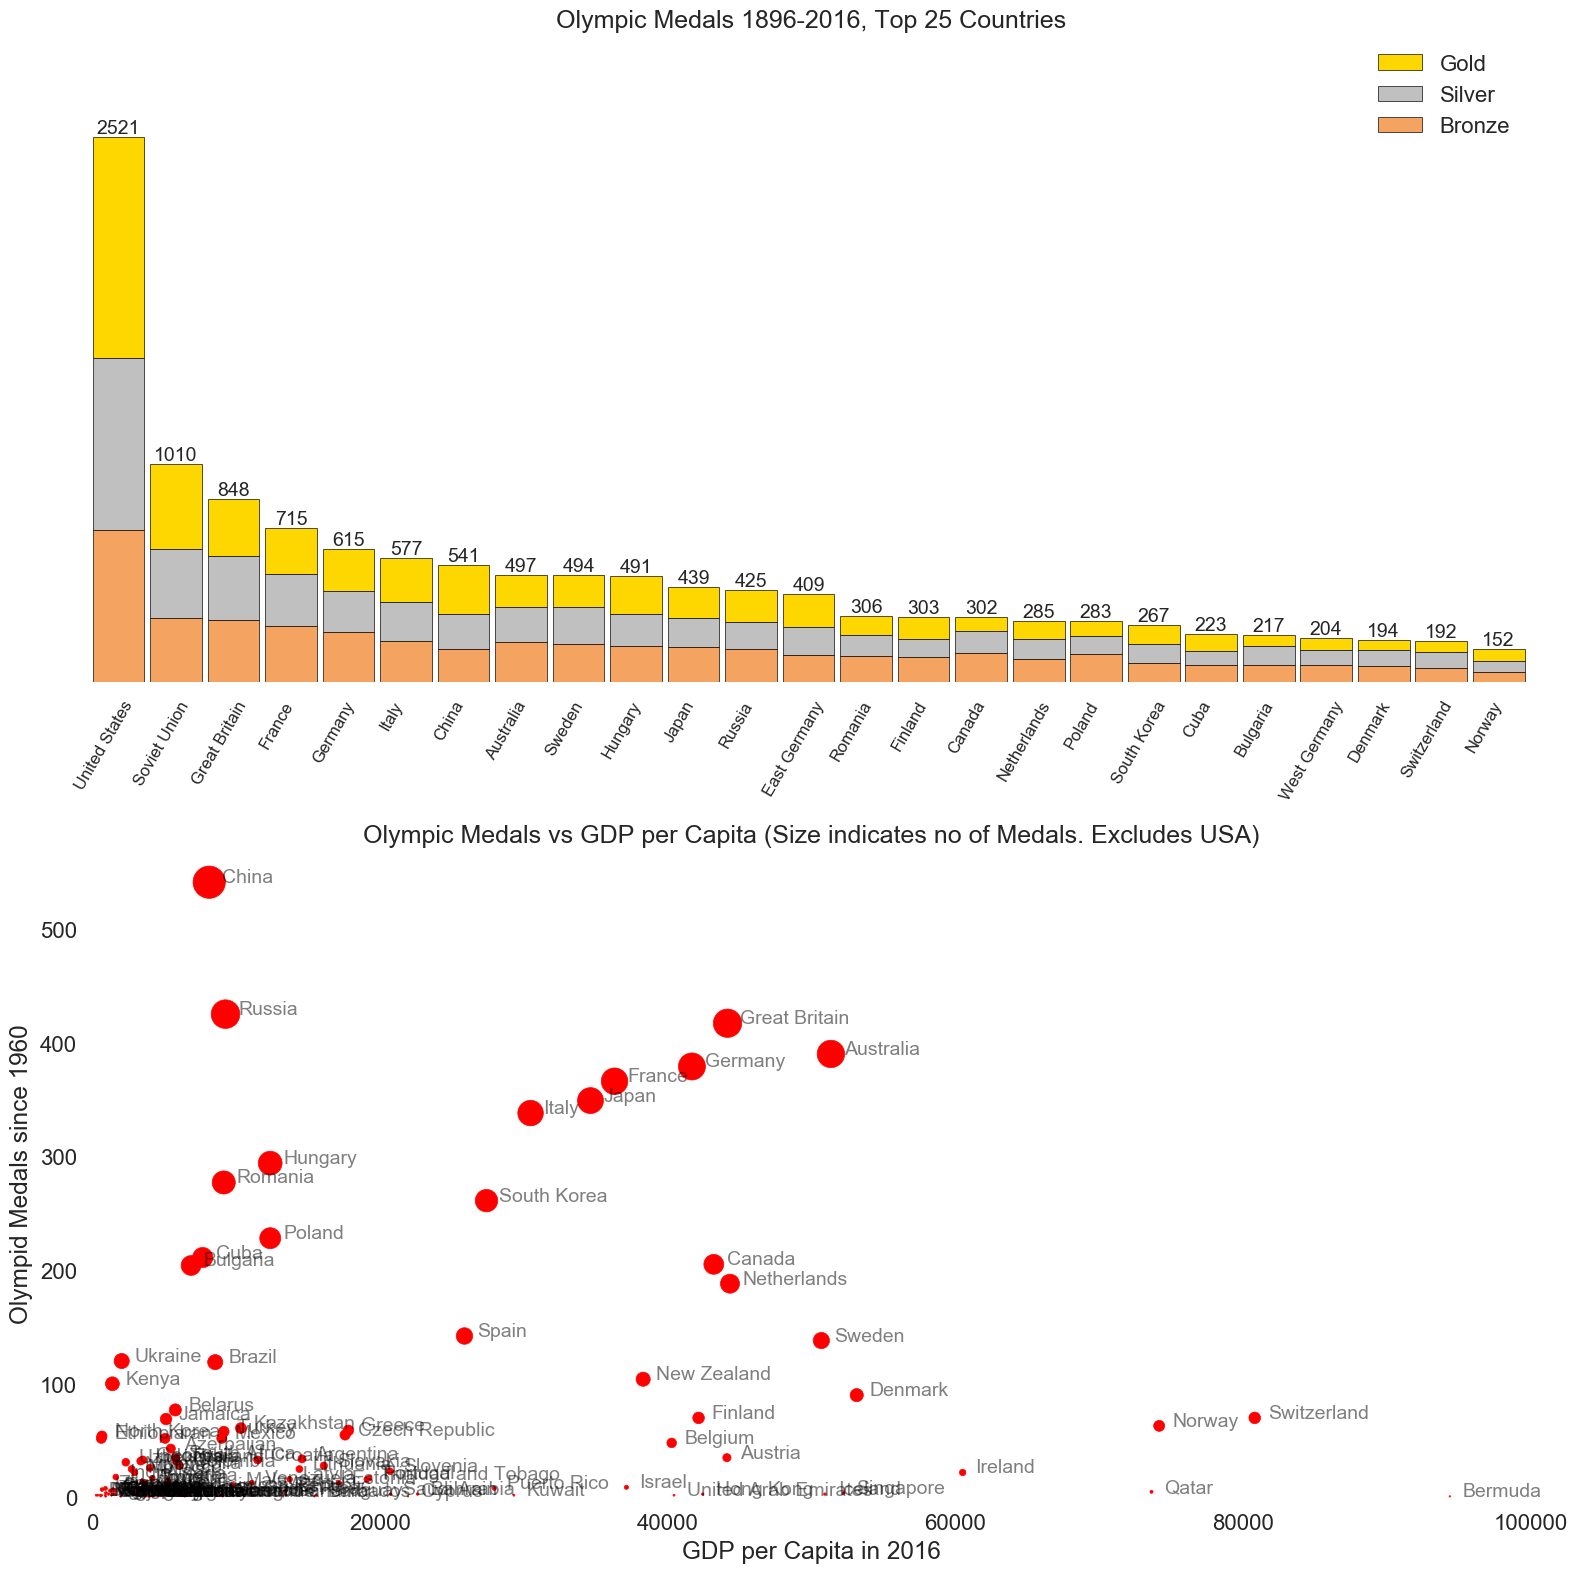

In [177]:
top = medals.groupby(medals.Nation, as_index=False).sum()
top = top[['Nation','Gold','Silver','Bronze','Total']].sort_values('Total', ascending=False 
                                                                  ).reset_index(drop=True)[:25]
#for style in plt.style.available:
_ = plt.style.use('seaborn-white')
_ = plt.figure(figsize=(16,16), frameon=False)
#_ = plt.suptitle('Olympic Medal Analyses', fontsize=20)

_ = plt.subplot(2,1,1)
_ = plt.title('Olympic Medals 1896-2016, Top 25 Countries', fontsize=18)
bars = plt.bar(top.index, top.Gold, width=0.9, color='gold', bottom=top.Silver+top.Bronze, label='Gold')
_ = plt.bar(top.index, top.Silver, width=0.9, color='silver', bottom=top.Bronze, label='Silver')
_ = plt.bar(top.index, top.Bronze, width=0.9, color='sandybrown', label='Bronze')
_ = plt.gca().spines['top'].set_visible(False)
_ = plt.gca().spines['right'].set_visible(False)
_ = plt.gca().spines['left'].set_visible(False)
_ = plt.gca().spines['bottom'].set_visible(False)
_ = plt.legend()
_ = plt.xticks(top.index+0.2, top.Nation, rotation=60, fontsize=12)
_ = plt.gca().patch.set_facecolor('white')
_ = plt.gca().yaxis.set_visible(False)

for i, bar in enumerate(bars):
    _ = plt.text(bar.get_x() + bar.get_width()/2, top.loc[i].Total, top.loc[i].Total, ha='center', va='bottom')

    
_ = plt.subplot(2,1,2)
_ = plt.title('Olympic Medals vs GDP per Capita (Size indicates no of Medals. Excludes USA)', fontsize=18)
_ = plt.scatter(total[total.Nation!='United States'].GDPCapita, total[total.Nation!='United States'].Total,
                color='red', s=total[total.Nation!='United States'].Total)
_ = plt.ylabel('Olympic Medals since 1960')
_ = plt.xlabel('GDP per Capita in 2016')
_ = plt.gca().axis([0,100000,0,570])
_ = plt.gca().spines['top'].set_visible(False)
_ = plt.gca().spines['right'].set_visible(False)
_ = plt.gca().spines['left'].set_visible(False)
_ = plt.gca().spines['bottom'].set_visible(False)
_ = plt.gca().axis('on')

for i, txt in enumerate(temp.Nation):
    _ = plt.gca().annotate(txt, (temp.loc[i].GDPCapita+900, temp.loc[i].Total), color='black', alpha=0.5)
    
_ = plt.tight_layout()
_ = plt.show()